Data source: https://www.kaggle.com/c/tabular-playground-series-jul-2021/data?select=train.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
pd.set_option("display.max_columns", None)

In [2]:
# Load dataset
# This notebook aims to forecast the "carbon monoxide"
trainSet = pd.read_csv('/content/train_time.csv')
trainSet['date_time'] = pd.to_datetime(trainSet['date_time'])
trainSet.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8


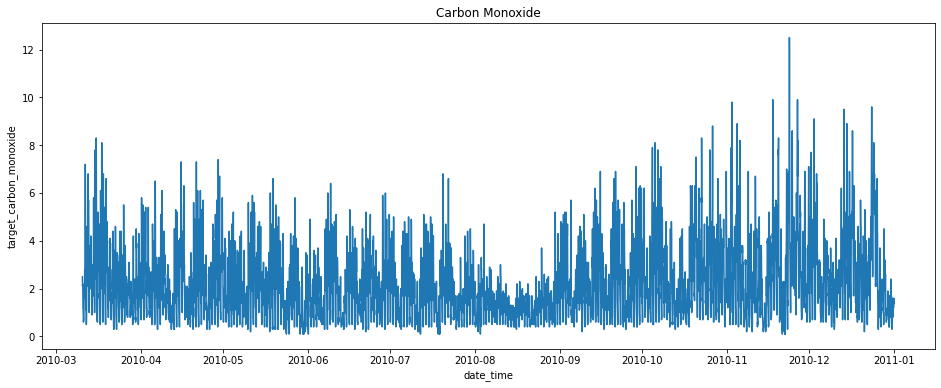

In [ ]:
# Plot all time
plt.figure(figsize=(16,6))
sns.lineplot(data=trainSet, x='date_time', y='target_carbon_monoxide')
plt.title('Carbon Monoxide')
plt.show()

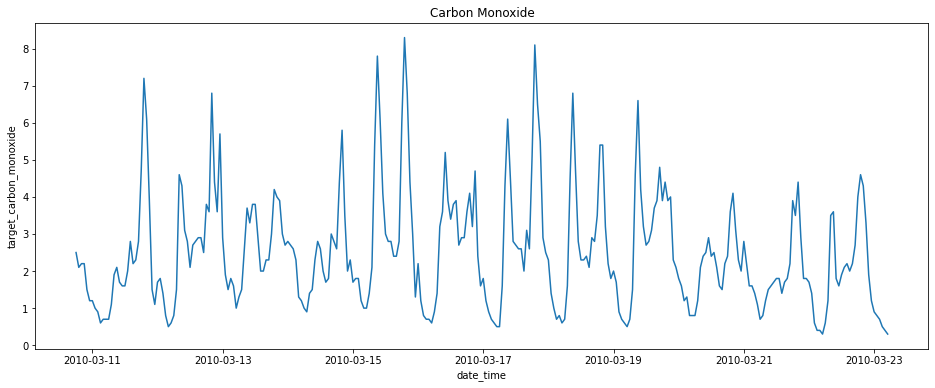

In [ ]:
# Plot early time
plt.figure(figsize=(16,6))
sns.lineplot(data=trainSet.iloc[:300,:], x='date_time', y='target_carbon_monoxide')
plt.title('Carbon Monoxide')
plt.show()

In [11]:
# Feature Engineering for training data
train = trainSet.reset_index(drop=True)

# Count
train['count'] = train.index

#  By date
train['year'] = train['date_time'].dt.year
train['month'] = train['date_time'].dt.month
train['day'] = train['date_time'].dt.day
train['date'] = train['date_time'].dt.day
train['dayofweek'] = train['date_time'].dt.dayofweek

# By time
train['hour'] = train['date_time'].dt.hour

train['target_carbon_monoxide_'] = train['target_carbon_monoxide']
train = train.drop(columns=['target_carbon_monoxide'])
train.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_benzene,target_nitrogen_oxides,count,year,month,day,date,dayofweek,hour,target_carbon_monoxide_
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,12.0,167.7,0,2010,3,10,10,2,18,2.5
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,9.9,98.9,1,2010,3,10,10,2,19,2.1
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,9.2,127.1,2,2010,3,10,10,2,20,2.2
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,9.7,177.2,3,2010,3,10,10,2,21,2.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,6.4,121.8,4,2010,3,10,10,2,22,1.5


In [42]:
train['target_carbon_monoxide_'].std()

1.4471092196951618

In [12]:
print(train['target_carbon_monoxide_'].max())
print(train['target_carbon_monoxide_'].min())

12.5
0.1


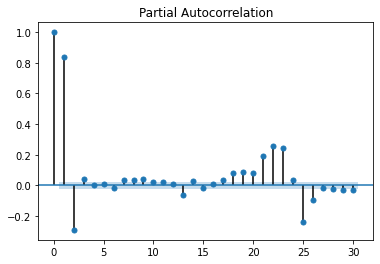

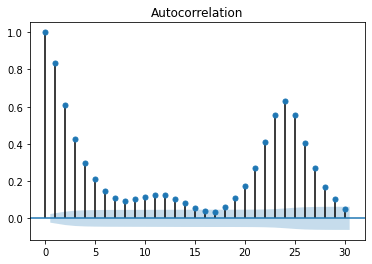

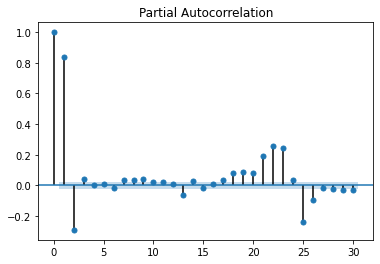

In [ ]:
# Autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train['target_carbon_monoxide_'], lags=30)
plot_pacf(train['target_carbon_monoxide_'], lags=30)

In [10]:
# Formatting for time series forecasting input
def format(input_data, lag=1, n_output=1, dropna=True):
	var = 1 if type(input_data) is list else input_data.shape[1]
	dataframe = pd.DataFrame(input_data)
	column, feature = list(), list()
	# lag time/shift (t-n, ... t-1)
	for i in range(lag, 0, -1):
		column.append(dataframe.shift(i))
		feature += [('feat%d(t-%d)' % (j+1, i)) for j in range(var)]
	# forecast (t, t+1, ... t+n)
	for i in range(0, n_output):
		column.append(dataframe.shift(-i))
		if i == 0:
			feature += [('feat%d(t)' % (j+1)) for j in range(var)]
		else:
			feature += [('feat%d(t+%d)' % (j+1, i)) for j in range(var)]
	# combine all
	combine = pd.concat(column, axis=1)
	combine.columns = feature
	# drop rows with na
	if dropna:
		combine.dropna(inplace=True)
	return combine

In [26]:
# MinMaxScaler
MinMax = MinMaxScaler()
train_scaled = MinMax.fit_transform(train.iloc[:,1:])

# Apply the formatting
data = format(input_data=train_scaled, lag=4, n_output=1, dropna=True)
data.head(6)

,feat1(t-4),feat2(t-4),feat3(t-4),feat4(t-4),feat5(t-4),feat6(t-4),feat7(t-4),feat8(t-4),feat9(t-4),feat10(t-4),feat11(t-4),feat12(t-4),feat13(t-4),feat14(t-4),feat15(t-4),feat16(t-4),feat17(t-4),feat18(t-4),feat1(t-3),feat2(t-3),feat3(t-3),feat4(t-3),feat5(t-3),feat6(t-3),feat7(t-3),feat8(t-3),feat9(t-3),feat10(t-3),feat11(t-3),feat12(t-3),feat13(t-3),feat14(t-3),feat15(t-3),feat16(t-3),feat17(t-3),feat18(t-3),feat1(t-2),feat2(t-2),feat3(t-2),feat4(t-2),feat5(t-2),feat6(t-2),feat7(t-2),feat8(t-2),feat9(t-2),feat10(t-2),feat11(t-2),feat12(t-2),feat13(t-2),feat14(t-2),feat15(t-2),feat16(t-2),feat17(t-2),feat18(t-2),feat1(t-1),feat2(t-1),feat3(t-1),feat4(t-1),feat5(t-1),feat6(t-1),feat7(t-1),feat8(t-1),feat9(t-1),feat10(t-1),feat11(t-1),feat12(t-1),feat13(t-1),feat14(t-1),feat15(t-1),feat16(t-1),feat17(t-1),feat18(t-1),feat1(t),feat2(t),feat3(t),feat4(t),feat5(t),feat6(t),feat7(t),feat8(t),feat9(t),feat10(t),feat11(t),feat12(t),feat13(t),feat14(t),feat15(t),feat16(t),feat17(t),feat18(t)
4,0.263393,0.452991,0.275071,0.522411,0.373362,0.330291,0.504003,0.446745,0.187107,0.112758,0.000000,0.0,0.181818,0.3,0.3,0.333333,0.782609,0.193548,0.265625,0.444444,0.259177,0.448774,0.270401,0.392990,0.379940,0.326630,0.154088,0.065968,0.000141,0.0,0.181818,0.300000,0.300000,0.333333,0.826087,0.161290,0.252232,0.577534,0.271332,0.484741,0.291757,0.332152,0.437630,0.371742,0.143082,0.085147,0.000281,0.0,0.181818,0.300000,0.300000,0.333333,0.869565,0.169355,0.216518,0.653236,0.289292,0.477316,0.291447,0.351072,0.416621,0.433905,0.150943,0.119219,0.000422,0.0,0.181818,0.300000,0.300000,0.333333,0.913043,0.169355,0.236607,0.611722,0.290326,0.443937,0.252089,0.385635,0.365369,0.378205,0.099057,0.081542,0.000563,0.0,0.181818,0.300000,0.300000,0.333333,0.956522,0.112903
5,0.265625,0.444444,0.259177,0.448774,0.270401,0.392990,0.379940,0.326630,0.154088,0.065968,0.000141,0.0,0.181818,0.3,0.3,0.333333,0.826087,0.161290,0.252232,0.577534,0.271332,0.484741,0.291757,0.332152,0.437630,0.371742,0.143082,0.085147,0.000281,0.0,0.181818,0.300000,0.300000,0.333333,0.869565,0.169355,0.216518,0.653236,0.289292,0.477316,0.291447,0.351072,0.416621,0.433905,0.150943,0.119219,0.000422,0.0,0.181818,0.300000,0.300000,0.333333,0.913043,0.169355,0.236607,0.611722,0.290326,0.443937,0.252089,0.385635,0.365369,0.378205,0.099057,0.081542,0.000563,0.0,0.181818,0.300000,0.300000,0.333333,0.956522,0.112903,0.220982,0.584860,0.288357,0.409128,0.172031,0.490340,0.385319,0.300310,0.067610,0.058624,0.000703,0.0,0.181818,0.300000,0.300000,0.333333,1.000000,0.088710
6,0.252232,0.577534,0.271332,0.484741,0.291757,0.332152,0.437630,0.371742,0.143082,0.085147,0.000281,0.0,0.181818,0.3,0.3,0.333333,0.869565,0.169355,0.216518,0.653236,0.289292,0.477316,0.291447,0.351072,0.416621,0.433905,0.150943,0.119219,0.000422,0.0,0.181818,0.300000,0.300000,0.333333,0.913043,0.169355,0.236607,0.611722,0.290326,0.443937,0.252089,0.385635,0.365369,0.378205,0.099057,0.081542,0.000563,0.0,0.181818,0.300000,0.300000,0.333333,0.956522,0.112903,0.220982,0.584860,0.288357,0.409128,0.172031,0.490340,0.385319,0.300310,0.067610,0.058624,0.000703,0.0,0.181818,0.300000,0.300000,0.333333,1.000000,0.088710,0.209821,0.571429,0.276302,0.425000,0.157485,0.523130,0.364310,0.224032,0.056604,0.039173,0.000844,0.0,0.181818,0.333333,0.333333,0.500000,0.000000,0.088710
7,0.216518,0.653236,0.289292,0.477316,0.291447,0.351072,0.416621,0.433905,0.150943,0.119219,0.000422,0.0,0.181818,0.3,0.3,0.333333,0.913043,0.169355,0.236607,0.611722,0.290326,0.443937,0.252089,0.385635,0.365369,0.378205,0.099057,0.081542,0.000563,0.0,0.181818,0.300000,0.300000,0.333333,0.956522,0.112903,0.220982,0.584860,0.288357,0.409128,0.172031,0.490340,0.385319,0.300310,0.067610,0.058624,0.000703,0.0,0.181818,0.300000,0.300000,0.333333,1.000000,0.088710,0.209821,0.571429,0.276302,0.425000,0.157485,0.523130,0.364310,0.224032,0.056604,0.039173,0.000844,0.0,0.181818,0.333333,0.333333,0.500000,0.000000,0.088710,0.200893,0.587302,0.281173,0.382221,0.138089,0.53

In [30]:
# Splitting training data (80%) and validation data (20%)
data2 = data.values
train2 = data2[:int(len(train)*0.8),:]
val = data2[int(len(train)*0.8):,:]

# Splitting x and y
X_train = train2[:,:-1]
y_train = train2[:,-1]
X_val = val[:,:-1]
y_val = val[:,-1]

# Reshape to (length, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

In [36]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [47]:
# Create and fit the LSTM model
lstm = Sequential()
lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
lstm.add(LSTM(50))
lstm.add(Dense(64, activation='relu'))
lstm.add(Dense(32, activation='relu'))
lstm.add(Dense(1))

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=1.0000e-03)
lstm.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae'])

# Set callbacks
es = EarlyStopping(monitor='mae', mode='min', verbose=0, patience=10)

# fit network
history = lstm.fit(X_train, y_train, epochs=50, batch_size=100, validation_data=(X_val, y_val), verbose=2, shuffle=False, callbacks=[es],)

Epoch 1/50
57/57 - 6s - loss: 0.0062 - mae: 0.0818 - val_loss: 0.0059 - val_mae: 0.0838
Epoch 2/50
57/57 - 0s - loss: 0.0018 - mae: 0.0420 - val_loss: 0.0035 - val_mae: 0.0500
Epoch 3/50
57/57 - 0s - loss: 8.2207e-04 - mae: 0.0292 - val_loss: 0.0029 - val_mae: 0.0460
Epoch 4/50
57/57 - 0s - loss: 6.6690e-04 - mae: 0.0262 - val_loss: 0.0028 - val_mae: 0.0437
Epoch 5/50
57/57 - 0s - loss: 6.0896e-04 - mae: 0.0247 - val_loss: 0.0026 - val_mae: 0.0415
Epoch 6/50
57/57 - 0s - loss: 5.9009e-04 - mae: 0.0244 - val_loss: 0.0024 - val_mae: 0.0404
Epoch 7/50
57/57 - 0s - loss: 5.9116e-04 - mae: 0.0247 - val_loss: 0.0024 - val_mae: 0.0397
Epoch 8/50
57/57 - 0s - loss: 6.0980e-04 - mae: 0.0254 - val_loss: 0.0023 - val_mae: 0.0396
Epoch 9/50
57/57 - 0s - loss: 6.2751e-04 - mae: 0.0262 - val_loss: 0.0023 - val_mae: 0.0396
Epoch 10/50
57/57 - 0s - loss: 5.8816e-04 - mae: 0.0255 - val_loss: 0.0023 - val_mae: 0.0385
Epoch 11/50
57/57 - 0s - loss: 4.9282e-04 - mae: 0.0230 - val_loss: 0.0022 - val_mae: 0

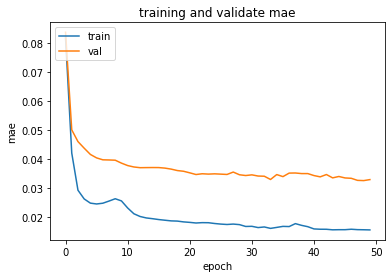

In [48]:
# Visualisasi history training 
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('training and validate mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The model successfully performed time series forecasting with 
- training MAE: 0.0155
- validation MAE: 0.0329.